# A comparison on how the cRBM and the cRTRBM explain the underlying structure and dynamics in sequential surrogate data

In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys
import os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

import sys
sys.path.append(r'D:\RU\OneDrive\Intern\rtrbm_master')

from data.mock_data import *
from utils.plots import * 
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM
from utils.funcs import *
from utils.visualize_hidden_network import *

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Create surrogate data

<AxesSubplot:>

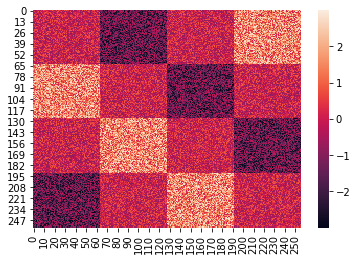

In [2]:
N=256
phigh=3#0.26
ilow=-3#0.26

def positive_connection(N, phigh):
    return np.random.uniform(low=0, high=phigh, size=(N//4,N//4))
def negative_connection(N, ilow):
    return np.random.uniform(low=ilow, high=0, size=(N//4,N//4))    
def neutral_connection(N):
    return np.random.uniform(low=-1, high=1, size=(N,N))    


# create large matrix W
W = neutral_connection(N)
W[0:N//4, N//4:N//2] = negative_connection(N, ilow)
W[N//4:N//2, N//2:3*N//4] = negative_connection(N, ilow)
W[N//2:3*N//4, 3*N//4:N] = negative_connection(N, ilow)
W[3*N//4:N, 0:N//4] = negative_connection(N, ilow)

W[N//4:N//2, 0:N//4] = positive_connection(N, phigh)
W[N//2:3*N//4, N//4:N//2] = positive_connection(N, phigh)
W[3*N//4:N, N//2:3*N//4] = positive_connection(N, phigh)
W[0:N//4, 3*N//4:N] = positive_connection(N, phigh)

sns.heatmap(W)

<AxesSubplot:>

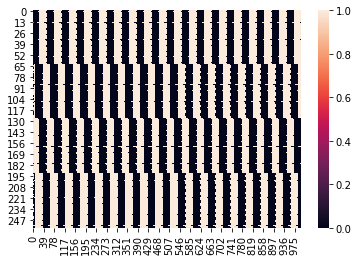

In [3]:
N_V = N
T = 1000
n_batches = 1
spikes = np.zeros(shape=(N, T, n_batches))
idx = torch.randperm(N)
for i in range(n_batches):
    spikes[:N//4, 0, i] = np.ones(N//4)#np.random.choice([0,1],size=(N))

    for t in range(1,T):
        spikes[:, t, i] = np.random.random(N) < (spikes[:,t-1, i]@W + np.random.uniform(0, 0.5,size=N))
        spikes[idx, t, i]
spikes = torch.reshape(torch.tensor(spikes), [N_V, T*n_batches])
sns.heatmap(spikes[:,:T])
#spikes = torch.reshape(spikes, [N, T])

Define coordinates

In [4]:
coordinates = torch.zeros(N, 2)

i = 0
shifted_x_position = np.array([0, np.sqrt(N/4), 0, np.sqrt(N/4)])
shifted_y_position = np.array([0, 0, np.sqrt(N/4), np.sqrt(N/4)])

for group in range(4):
    for y in range(int(np.sqrt(N/4))):
        for x in range(int(np.sqrt(N/4))):
            coordinates[i,0] = x + shifted_x_position[group]
            coordinates[i,1] = y + shifted_y_position[group]
            i+=1
#plt.scatter(coordinates[:,0], coordinates[:,1])

## Activity over time

<IPython.core.display.Javascript object>


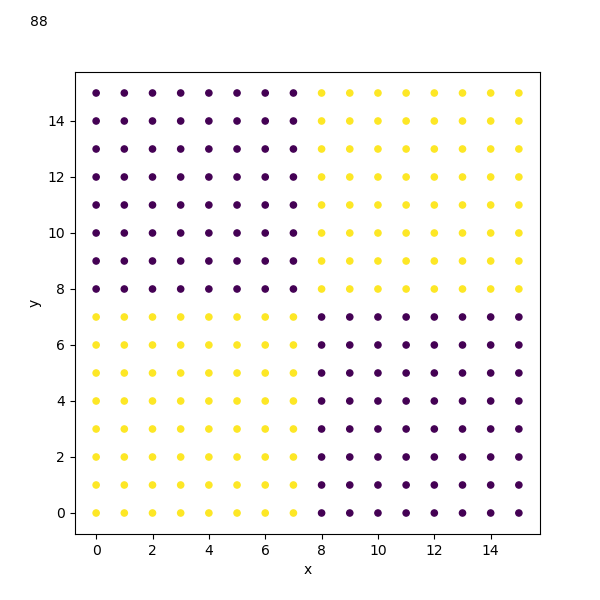

In [5]:
%matplotlib notebook

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


snapshots_spikes = [ spikes[:, t] for t in range(T) ] 

#plt.clf()
fig, ax = plt.subplots(figsize=(6,6))

scat = ax.scatter(coordinates[:, 0], coordinates[:, 1],
               s=20,
               c = snapshots_spikes[0])

# add another axes at the top left corner of the figure
axtext = fig.add_axes([0.0,0.95,0.1,0.05])

# turn the axis labels/spines/ticks off
axtext.axis("off")

time = axtext.text(0.5,0.5, str(0), ha="left", va="top")

def animate_func(i, data, scat):
    # clear the axis each frame
    ax.clear()

    # replot things
    ax.scatter(coordinates[:, 0], coordinates[:, 1],
               s=20,
               c = snapshots_spikes[i])
    
    # reformat things
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    time.set_text(str(i))

    return [time] 

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = T,
                               interval = 1, # in ms
                               blit=False, fargs=(spikes, scat))
                               
plt.show()

## Train cRBM and cRTRBM

In [6]:
n_epochs = 100
N_H = 4

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


Text(0, 0.5, 'RMS error')

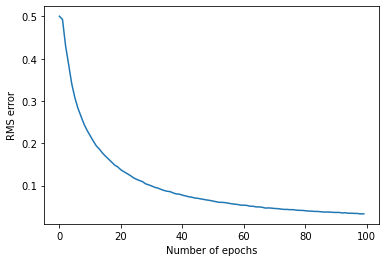

In [7]:
%matplotlib inline

crbm = RBM(spikes, N_H = N_H)

crbm.learn(n_epochs=n_epochs,
              lr=1e-4,
              sp=None, x=2)

plt.plot(crbm.errors) 
plt.xlabel("Number of epochs")
plt.ylabel("RMS error")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


Text(0, 0.5, 'RMS error')

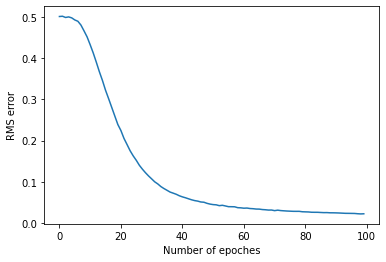

In [8]:
%matplotlib inline
crtrbm = RTRBM(spikes, N_H = N_H)

crtrbm.learn(n_epochs=n_epochs,
              lr=1e-4,
              sp=None, x=2)

plt.plot(crtrbm.errors)
plt.xlabel("Number of epoches")
plt.ylabel("RMS error")

## Weights and coupling cRBM

In [9]:
# load if necessary

path = os.path.dirname(os.getcwd())
crtrbm = pickle.load(open(path + '\\results\\RTRBMs\\cRTRBM sequential surrogate data lr=1e-4 sp=None.pkl', 'rb'))
crbm = pickle.load(open(path + '\\results\\RTRBMs\\cRBM sequential surrogate data lr=1e-4 sp=None.pkl', 'rb'))

In [10]:
h = torch.zeros(N_H,T)
for t in range(T):
    h[:,t], _ = crbm.visible_to_hidden_rbm(0)

plot_effective_coupling_VH(crbm[0][0], crbm[0][4].float(), h )

ValueError: too many values to unpack (expected 2)

## Weights and coupling cRTRBM

In [ ]:
plot_effective_coupling_VH_HH(crtrbm.W, crtrbm.W_acc, spikes.float(), \
                              crtrbm.visible_to_expected_hidden(spikes.float(), AF=torch.sigmoid) )

## Receptive field cRBM

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

VH = crbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, coordinates)
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, edgecolors = 'b')
ax.scatter(rf[:, 0], rf[:, 1], s=20, edgecolors = 'r')

ax.set_xlabel('x')
ax.set_ylabel('y')


In [ ]:
import matplotlib as mpl

VH = crbm.W.detach().clone()

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
max_hidden_connection = torch.max(VH, 0)[1]
strong_thresh = 0.5 * torch.std(VH)
h = 0
for i in range(2):
    for j in range(2):
        idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
        idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
        idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
        idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))

        ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

        ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
        ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'green', marker='v')

        ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^')
        ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker='v')

        h +=1
            
    #mpl.style.use('seaborn')

## Receptive field cRTRBM

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

VH = crtrbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, coordinates)
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, edgecolors = 'b')
ax.scatter(rf[:, 0], rf[:, 1], s=20, edgecolors = 'r')

ax.set_xlabel('x')
ax.set_ylabel('y')


In [ ]:
import matplotlib as mpl

VH = crtrbm.W.detach().clone()

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
max_hidden_connection = torch.max(VH, 0)[1]
strong_thresh = 0.5 * torch.std(VH)
h = 0
for i in range(2):
    for j in range(2):
        idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
        idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
        idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
        idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))

        ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

        ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
        ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'green', marker='v')

        ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^')
        ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker='v')

        h +=1
            
    #mpl.style.use('seaborn')

In [ ]:
#del create_plot, line_between_two_neurons
#from utils.visualize_hidden_network import create_plot

create_plot(crtrbm.W, crtrbm.W_acc, rf, coordinates, dy=0.1, markersize_visibles=50, hiddens_radius=0.04)

## Compare the moments of the cRBM and the cRTRBM

In [ ]:
N_V = N
T = 1000
n_batches = 2
spikes = np.zeros(shape=(N, T, n_batches))
idx = torch.randperm(N)
for i in range(n_batches):
    spikes[:N//4, 0, i] = np.ones(N//4)#np.random.choice([0,1],size=(N))

    for t in range(1,T):
        spikes[:, t, i] = np.random.random(N) < (spikes[:,t-1, i]@W + np.random.uniform(0, 0.5,size=N))
        spikes[idx, t, i]

In [ ]:
plot_compare_moments(crbm, crtrbm, spikes[:,3*T//10:,1], spikes[:,3*T//10:, 1], MC_chains=300, pre_gibbs_k=50, gibbs_k=20)

## Save parameters

In [ ]:
from utils.create_param_class import Parameters
import pickle
import os

def save_object(obj, filename):
    if not os.path.isfile(filename):
        with open(filename,'wb') as file:
            pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

cRBM_parameters = Parameters()
cRTRBM_parameters = Parameters()

# Safe parameters & coordinates
crbm.params = [crbm.W, crbm.b_V, crbm.b_H, crbm.errors, spikes, coordinates] 
cRBM_parameters.add_params(crbm)
filename = "cRBM sequential surrogate data lr=1e-4 sp=None.pkl"  
save_object(cRBM_parameters, filename)

#crtrbm.params = [crtrbm.W, crtrbm.W_acc, crtrbm.b_V, crtrbm.b_H, crtrbm.b_init, crtrbm.errors, spikes, coordinates] 
#cRTRBM_parameters.add_params(crtrbm)
#filename = "cRTRBM sequential surrogate data lr=1e-4 sp=None.pkl"  
#save_object(cRTRBM_parameters, filename)


In [1]:
for t in range(32 - 1, -1, -1):
    print(t)

31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
